### 120316_0855
* repeat of first run without regularization; added history and metrics tracking

### 120316_0000
* change to run with regularization

### 120116_1223
* run with cleaned dataset, just on damage severity, 256x256, 8 batch size, theano backend
* loss: 0.5195 - acc: 0.7763 - val_loss: 0.5586 - val_acc: 0.7544

In [1]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
from sklearn.metrics import classification_report, confusion_matrix

sns.set_palette("cubehelix")
sns.set_style('whitegrid')

In [2]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

/home/milhouse/tools/virtualenvs/car-damage-detective-2/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [3]:
def load_vgg16(weights_path='vgg16_weights_th_dim_ordering_th_kernels_notop.h5'):
#def load_vgg16(weights_path='../vgg16_weights.h5'):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3, img_width, img_height)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    print(weights_path)
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path")'
    
    if weights_path:
    # note: this chops off the last layers of VGG16 

    # loads the weights of the VGG16 networks
    # note: when there is a complete match between model definition
    # and your weights savefile, you can simply call model.load_weights(filename)
        
        model.load_weights(weights_path)
       
        print('VGG16 Model with partial weights loaded.')
    else:
        print('VGG16 Model with no weights Loaded.')

    return model

In [4]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    print "Generator done"
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    print "Prediction done"
    np.save(open(location+'/bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    print "Bottleneck saved"
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    print "Generator val done"
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    print "Prediction val done"
    np.save(open(location+'/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)
    print "Bottleneck val saved done"

In [5]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print 'epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch]

In [6]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print "Best Model:" 
    print_best_model_results(hist)

In [7]:
def train_categorical_model():
    train_data = np.load(open(location+'/bottleneck_features_train.npy'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy'))
    validation_labels = np.array([0] * (validation_samples[0]) + 
                                 [1] * (validation_samples[1]) +
                                 [2] * (validation_samples[2]))
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax')) # upped to 3 and activation softmax

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9), # reduced learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

    # model.compile(optimizer='rmsprop', 
    #               loss='categorical_crossentropy', metrics=['accuracy']) 
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              nb_epoch=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [8]:
def finetune_categorical_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base
    model.add(top_model)
    
    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False

    model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(lr=0.000001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
        
    # fine-tune the model
    fit = model.fit_generator(train_generator,
                              samples_per_epoch=nb_train_samples,
                              nb_epoch=nb_epoch,
                              validation_data=validation_generator,
                              nb_val_samples=nb_validation_samples,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'wb') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [9]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)

    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [10]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = raw_input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

## Defining Input Data

In [11]:
# path to the model weights file
location = 'data3_1'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [12]:
# do not rerun!
save_bottleneck_features(location)

vgg16_weights_th_dim_ordering_th_kernels_notop.h5
VGG16 Model with partial weights loaded.
Found 979 images belonging to 3 classes.
Generator done
Prediction done
Bottleneck saved
Found 171 images belonging to 3 classes.
Generator val done
Prediction val done
Bottleneck val saved done


## Model Parameter Selection

In [13]:
# WINNER
d3_model2, d3_hist2 = train_categorical_model() # no regularization

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1650 - acc: 0.4249 - val_loss: 0.9540 - val_acc: 0.5789
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9696 - acc: 0.5138 - val_loss: 0.8977 - val_acc: 0.5965
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.8962 - acc: 0.5751 - val_loss: 0.9487 - val_acc: 0.5263
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8910 - acc: 0.5659 - val_loss: 0.8592 - val_acc: 0.6023
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8198 - acc: 0.6292 - val_loss: 0.8338 - val_acc: 0.5965
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7720 - acc: 0.6435 - val_loss: 0.8192 - val_acc: 0.6374
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7657 - acc: 0.6639 - val_loss: 0.7970 - val_acc: 0.6608
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7523 - acc: 0.6629

979/979 [==============================] - 20s - loss: 0.3520 - acc: 0.8917 - val_loss: 0.7573 - val_acc: 0.6316
Epoch 34/50
979/979 [==============================] - 20s - loss: 0.3391 - acc: 0.8958 - val_loss: 0.7932 - val_acc: 0.6491
Epoch 35/50
979/979 [==============================] - 20s - loss: 0.3525 - acc: 0.8836 - val_loss: 0.7940 - val_acc: 0.6374
Epoch 36/50
979/979 [==============================] - 20s - loss: 0.3333 - acc: 0.8856 - val_loss: 0.7623 - val_acc: 0.6199
Epoch 37/50
979/979 [==============================] - 20s - loss: 0.3151 - acc: 0.9040 - val_loss: 0.7744 - val_acc: 0.6257
Epoch 38/50
979/979 [==============================] - 20s - loss: 0.2917 - acc: 0.9285 - val_loss: 0.8168 - val_acc: 0.6082
Epoch 39/50
979/979 [==============================] - 20s - loss: 0.2993 - acc: 0.9162 - val_loss: 0.7877 - val_acc: 0.6374
Epoch 40/50
979/979 [==============================] - 20s - loss: 0.3011 - acc: 0.8979 - val_loss: 0.7724 - val_acc: 0.6199
Epoch 41/50


In [14]:
d3_model, d3_hist = train_categorical_model() # l2 regularization, sgd lr = 0.0001

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1733 - acc: 0.4014 - val_loss: 0.9883 - val_acc: 0.5497
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9693 - acc: 0.5189 - val_loss: 0.9035 - val_acc: 0.6140
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.9386 - acc: 0.5414 - val_loss: 0.9097 - val_acc: 0.5848
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8759 - acc: 0.5843 - val_loss: 0.8569 - val_acc: 0.6082
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8245 - acc: 0.6108 - val_loss: 0.8574 - val_acc: 0.5848
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7915 - acc: 0.6599 - val_loss: 0.8269 - val_acc: 0.6374
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7538 - acc: 0.6568 - val_loss: 0.7926 - val_acc: 0.6199
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7139 - acc: 0.7028

979/979 [==============================] - 20s - loss: 0.3448 - acc: 0.8938 - val_loss: 0.7524 - val_acc: 0.6199
Epoch 34/50
979/979 [==============================] - 20s - loss: 0.3390 - acc: 0.8989 - val_loss: 0.7610 - val_acc: 0.6491
Epoch 35/50
979/979 [==============================] - 20s - loss: 0.3158 - acc: 0.9040 - val_loss: 0.7617 - val_acc: 0.6433
Epoch 36/50
979/979 [==============================] - 20s - loss: 0.3062 - acc: 0.9193 - val_loss: 0.7900 - val_acc: 0.6667
Epoch 37/50
979/979 [==============================] - 20s - loss: 0.3048 - acc: 0.9070 - val_loss: 0.7701 - val_acc: 0.6374
Epoch 38/50
979/979 [==============================] - 20s - loss: 0.2902 - acc: 0.9101 - val_loss: 0.7725 - val_acc: 0.6316
Epoch 39/50
979/979 [==============================] - 20s - loss: 0.2865 - acc: 0.9183 - val_loss: 0.7910 - val_acc: 0.6140
Epoch 40/50
979/979 [==============================] - 20s - loss: 0.2869 - acc: 0.9244 - val_loss: 0.8139 - val_acc: 0.6316
Epoch 41/50


In [15]:
d3_model3, d3_hist3 = train_categorical_model() # l1 regularization

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1532 - acc: 0.4014 - val_loss: 1.0095 - val_acc: 0.5205
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9920 - acc: 0.5026 - val_loss: 0.9020 - val_acc: 0.5965
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.9055 - acc: 0.5618 - val_loss: 0.8720 - val_acc: 0.6374
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8612 - acc: 0.5986 - val_loss: 0.8363 - val_acc: 0.6550
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8295 - acc: 0.6057 - val_loss: 0.8182 - val_acc: 0.6433
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7696 - acc: 0.6466 - val_loss: 0.8399 - val_acc: 0.6082
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7404 - acc: 0.6813 - val_loss: 0.7751 - val_acc: 0.6257
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7533 - acc: 0.6374

979/979 [==============================] - 20s - loss: 0.3723 - acc: 0.8744 - val_loss: 0.7548 - val_acc: 0.6550
Epoch 34/50
979/979 [==============================] - 20s - loss: 0.3482 - acc: 0.8968 - val_loss: 0.7705 - val_acc: 0.6725
Epoch 35/50
979/979 [==============================] - 20s - loss: 0.3295 - acc: 0.8989 - val_loss: 0.7597 - val_acc: 0.6491
Epoch 36/50
979/979 [==============================] - 20s - loss: 0.3328 - acc: 0.8979 - val_loss: 0.7836 - val_acc: 0.6608
Epoch 37/50
979/979 [==============================] - 20s - loss: 0.3066 - acc: 0.9183 - val_loss: 0.7628 - val_acc: 0.6433
Epoch 38/50
979/979 [==============================] - 20s - loss: 0.3127 - acc: 0.9111 - val_loss: 0.7759 - val_acc: 0.6433
Epoch 39/50
979/979 [==============================] - 20s - loss: 0.2883 - acc: 0.9203 - val_loss: 0.7711 - val_acc: 0.6257
Epoch 40/50
979/979 [==============================] - 20s - loss: 0.2733 - acc: 0.9234 - val_loss: 0.7975 - val_acc: 0.6140
Epoch 41/50


In [16]:
d3_model4, d3_hist4 = train_categorical_model() # double dense and dropout layers

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1902 - acc: 0.3984 - val_loss: 0.9669 - val_acc: 0.5556
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9728 - acc: 0.5107 - val_loss: 0.9092 - val_acc: 0.5614
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.8901 - acc: 0.5771 - val_loss: 0.8818 - val_acc: 0.5789
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8584 - acc: 0.5873 - val_loss: 0.8143 - val_acc: 0.6257
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.7935 - acc: 0.6415 - val_loss: 0.8000 - val_acc: 0.6199
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7591 - acc: 0.6578 - val_loss: 0.7833 - val_acc: 0.6374
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7358 - acc: 0.6599 - val_loss: 0.7883 - val_acc: 0.6374
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.6950 - acc: 0.6885

979/979 [==============================] - 20s - loss: 0.3228 - acc: 0.8968 - val_loss: 0.7752 - val_acc: 0.6374
Epoch 33/50
979/979 [==============================] - 20s - loss: 0.3032 - acc: 0.9132 - val_loss: 0.7612 - val_acc: 0.6257
Epoch 34/50
979/979 [==============================] - 20s - loss: 0.3138 - acc: 0.9040 - val_loss: 0.8242 - val_acc: 0.6550
Epoch 35/50
979/979 [==============================] - 20s - loss: 0.3021 - acc: 0.9152 - val_loss: 0.7779 - val_acc: 0.6257
Epoch 36/50
979/979 [==============================] - 20s - loss: 0.2928 - acc: 0.9152 - val_loss: 0.7791 - val_acc: 0.6082
Epoch 37/50
979/979 [==============================] - 20s - loss: 0.2895 - acc: 0.9142 - val_loss: 0.7731 - val_acc: 0.6140
Epoch 38/50
979/979 [==============================] - 20s - loss: 0.2668 - acc: 0.9213 - val_loss: 0.7881 - val_acc: 0.6257
Epoch 39/50
979/979 [==============================] - 20s - loss: 0.2496 - acc: 0.9326 - val_loss: 0.8086 - val_acc: 0.6433
Epoch 40/50


In [17]:
d3_model5, d3_hist5 = train_categorical_model() # double dense and dropout layers with regularization

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1282 - acc: 0.4321 - val_loss: 1.0238 - val_acc: 0.3801
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9505 - acc: 0.5465 - val_loss: 0.8970 - val_acc: 0.5556
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.9060 - acc: 0.5618 - val_loss: 0.8847 - val_acc: 0.6023
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8667 - acc: 0.6088 - val_loss: 0.8512 - val_acc: 0.5906
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8284 - acc: 0.6272 - val_loss: 0.8790 - val_acc: 0.5614
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7967 - acc: 0.6292 - val_loss: 0.8625 - val_acc: 0.5614
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7702 - acc: 0.6588 - val_loss: 0.8045 - val_acc: 0.6257
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7336 - acc: 0.6609

979/979 [==============================] - 19s - loss: 0.3725 - acc: 0.8631 - val_loss: 0.7644 - val_acc: 0.6608
Epoch 33/50
979/979 [==============================] - 19s - loss: 0.3550 - acc: 0.8876 - val_loss: 0.7689 - val_acc: 0.6667
Epoch 34/50
979/979 [==============================] - 19s - loss: 0.3358 - acc: 0.8968 - val_loss: 0.7683 - val_acc: 0.6550
Epoch 35/50
979/979 [==============================] - 19s - loss: 0.3288 - acc: 0.8846 - val_loss: 0.7891 - val_acc: 0.6433
Epoch 36/50
979/979 [==============================] - 19s - loss: 0.3244 - acc: 0.9030 - val_loss: 0.7793 - val_acc: 0.6667
Epoch 37/50
979/979 [==============================] - 19s - loss: 0.2981 - acc: 0.9183 - val_loss: 0.7769 - val_acc: 0.6491
Epoch 38/50
979/979 [==============================] - 19s - loss: 0.3082 - acc: 0.9050 - val_loss: 0.7974 - val_acc: 0.6433
Epoch 39/50
979/979 [==============================] - 19s - loss: 0.2860 - acc: 0.9101 - val_loss: 0.7720 - val_acc: 0.6374
Epoch 40/50


In [18]:
d3_model6, d3_hist6 = train_categorical_model() # double dense with aggressive dropout

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1689 - acc: 0.3994 - val_loss: 0.9730 - val_acc: 0.5322
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9784 - acc: 0.5158 - val_loss: 1.0687 - val_acc: 0.4327
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.9102 - acc: 0.5618 - val_loss: 0.8829 - val_acc: 0.5673
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8325 - acc: 0.6108 - val_loss: 0.8310 - val_acc: 0.6608
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8160 - acc: 0.6261 - val_loss: 0.8580 - val_acc: 0.5789
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7858 - acc: 0.6435 - val_loss: 0.8565 - val_acc: 0.6257
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7599 - acc: 0.6670 - val_loss: 0.7817 - val_acc: 0.6959
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7047 - acc: 0.7028

979/979 [==============================] - 20s - loss: 0.3410 - acc: 0.8907 - val_loss: 0.7737 - val_acc: 0.6491
Epoch 34/50
979/979 [==============================] - 20s - loss: 0.3198 - acc: 0.8917 - val_loss: 0.7709 - val_acc: 0.6374
Epoch 35/50
979/979 [==============================] - 20s - loss: 0.3128 - acc: 0.8999 - val_loss: 0.7764 - val_acc: 0.6199
Epoch 36/50
979/979 [==============================] - 20s - loss: 0.3130 - acc: 0.9101 - val_loss: 0.7637 - val_acc: 0.6491
Epoch 37/50
979/979 [==============================] - 20s - loss: 0.2644 - acc: 0.9346 - val_loss: 0.7751 - val_acc: 0.6316
Epoch 38/50
979/979 [==============================] - 20s - loss: 0.2727 - acc: 0.9224 - val_loss: 0.7917 - val_acc: 0.6257
Epoch 39/50
979/979 [==============================] - 20s - loss: 0.2893 - acc: 0.9193 - val_loss: 0.7909 - val_acc: 0.6433
Epoch 40/50
979/979 [==============================] - 20s - loss: 0.2769 - acc: 0.9244 - val_loss: 0.8141 - val_acc: 0.6433
Epoch 41/50


In [19]:
d3_model7, d3_hist7 = train_categorical_model() # l2 regularization and aggresive dropout

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1909 - acc: 0.4116 - val_loss: 1.0195 - val_acc: 0.4912
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9866 - acc: 0.5189 - val_loss: 0.9553 - val_acc: 0.5439
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.9377 - acc: 0.5567 - val_loss: 0.9723 - val_acc: 0.5380
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8689 - acc: 0.5914 - val_loss: 0.9265 - val_acc: 0.5497
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8428 - acc: 0.6221 - val_loss: 0.8638 - val_acc: 0.5731
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7896 - acc: 0.6435 - val_loss: 0.8494 - val_acc: 0.6550
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7959 - acc: 0.6302 - val_loss: 0.9125 - val_acc: 0.5673
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7598 - acc: 0.6629

979/979 [==============================] - 21s - loss: 0.3297 - acc: 0.8979 - val_loss: 0.8099 - val_acc: 0.6140
Epoch 34/50
979/979 [==============================] - 21s - loss: 0.3272 - acc: 0.8989 - val_loss: 0.8162 - val_acc: 0.6082
Epoch 35/50
979/979 [==============================] - 21s - loss: 0.3175 - acc: 0.9050 - val_loss: 0.8363 - val_acc: 0.6257
Epoch 36/50
979/979 [==============================] - 21s - loss: 0.2840 - acc: 0.9193 - val_loss: 0.8276 - val_acc: 0.6199
Epoch 37/50
979/979 [==============================] - 21s - loss: 0.2789 - acc: 0.9265 - val_loss: 0.8089 - val_acc: 0.6140
Epoch 38/50
979/979 [==============================] - 21s - loss: 0.2896 - acc: 0.9142 - val_loss: 0.8211 - val_acc: 0.6023
Epoch 39/50
979/979 [==============================] - 21s - loss: 0.2656 - acc: 0.9234 - val_loss: 0.8166 - val_acc: 0.6140
Epoch 40/50
979/979 [==============================] - 21s - loss: 0.2600 - acc: 0.9203 - val_loss: 0.8317 - val_acc: 0.6023
Epoch 41/50


In [20]:
d3_model8, d3_hist8 = train_categorical_model() # l2 regularization, rmsprop

Train on 979 samples, validate on 171 samples
Epoch 1/50
979/979 [==============================] - 14s - loss: 1.1850 - acc: 0.4014 - val_loss: 0.9811 - val_acc: 0.5497
Epoch 2/50
979/979 [==============================] - 14s - loss: 0.9802 - acc: 0.5148 - val_loss: 0.9272 - val_acc: 0.5906
Epoch 3/50
979/979 [==============================] - 14s - loss: 0.9065 - acc: 0.5628 - val_loss: 0.9093 - val_acc: 0.5497
Epoch 4/50
979/979 [==============================] - 14s - loss: 0.8635 - acc: 0.6037 - val_loss: 0.8771 - val_acc: 0.5848
Epoch 5/50
979/979 [==============================] - 14s - loss: 0.8127 - acc: 0.6313 - val_loss: 0.8486 - val_acc: 0.6082
Epoch 6/50
979/979 [==============================] - 14s - loss: 0.7823 - acc: 0.6527 - val_loss: 0.8107 - val_acc: 0.6023
Epoch 7/50
979/979 [==============================] - 14s - loss: 0.7395 - acc: 0.6823 - val_loss: 0.8052 - val_acc: 0.6257
Epoch 8/50
979/979 [==============================] - 14s - loss: 0.7295 - acc: 0.6793

979/979 [==============================] - 20s - loss: 0.3483 - acc: 0.8876 - val_loss: 0.7760 - val_acc: 0.6257
Epoch 33/50
979/979 [==============================] - 19s - loss: 0.3563 - acc: 0.8795 - val_loss: 0.8201 - val_acc: 0.6316
Epoch 34/50
979/979 [==============================] - 20s - loss: 0.3106 - acc: 0.9060 - val_loss: 0.7895 - val_acc: 0.6550
Epoch 35/50
979/979 [==============================] - 19s - loss: 0.3035 - acc: 0.9152 - val_loss: 0.7663 - val_acc: 0.6316
Epoch 36/50
979/979 [==============================] - 20s - loss: 0.2976 - acc: 0.9101 - val_loss: 0.7764 - val_acc: 0.6199
Epoch 37/50
979/979 [==============================] - 20s - loss: 0.2816 - acc: 0.9203 - val_loss: 0.8005 - val_acc: 0.6257
Epoch 38/50
979/979 [==============================] - 20s - loss: 0.2823 - acc: 0.9142 - val_loss: 0.7835 - val_acc: 0.5906
Epoch 39/50
979/979 [==============================] - 20s - loss: 0.2551 - acc: 0.9285 - val_loss: 0.8043 - val_acc: 0.6082
Epoch 40/50


Best Model:
epoch: 9 , val_acc: 0.6666666677123622 , val_loss: 0.794651426767048


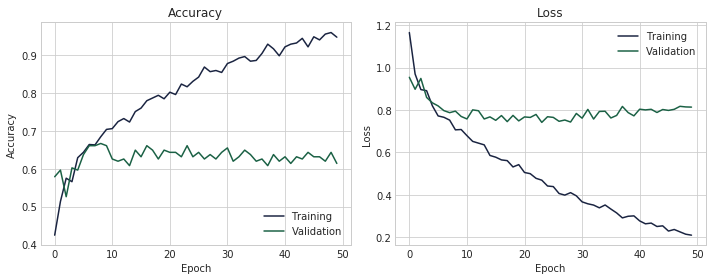

In [21]:
# WINNER
plot_metrics(d3_hist2)

Best Model:
epoch: 15 , val_acc: 0.6725146209287365 , val_loss: 0.7627478653227376


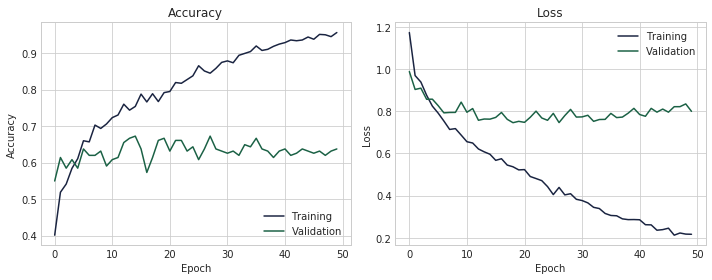

In [22]:
plot_metrics(d3_hist)

Best Model:
epoch: 16 , val_acc: 0.6725146212773017 , val_loss: 0.7381334702173868


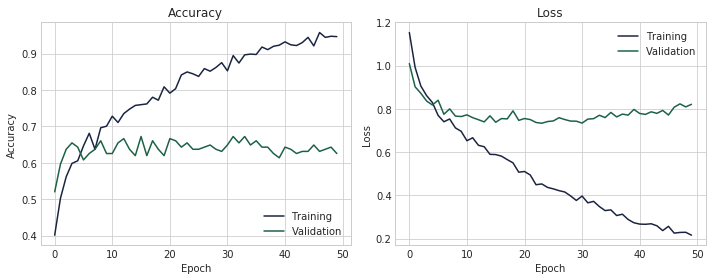

In [23]:
plot_metrics(d3_hist3)

Best Model:
epoch: 16 , val_acc: 0.660818714495988 , val_loss: 0.7425705685950162


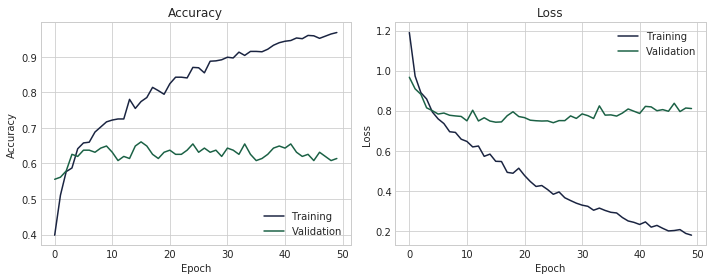

In [24]:
plot_metrics(d3_hist4)

Best Model:
epoch: 33 , val_acc: 0.6666666659695363 , val_loss: 0.7689289109051576


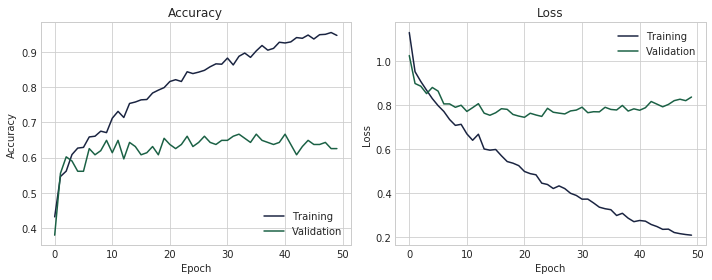

In [25]:
plot_metrics(d3_hist5)

Best Model:
epoch: 7 , val_acc: 0.6959064337942336 , val_loss: 0.7816899969563846


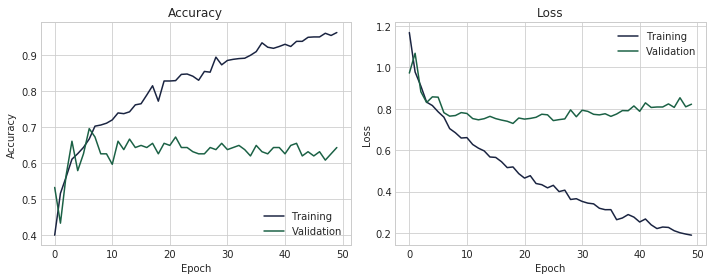

In [26]:
plot_metrics(d3_hist6)

Best Model:
epoch: 24 , val_acc: 0.6608187148445531 , val_loss: 0.7668635360678734


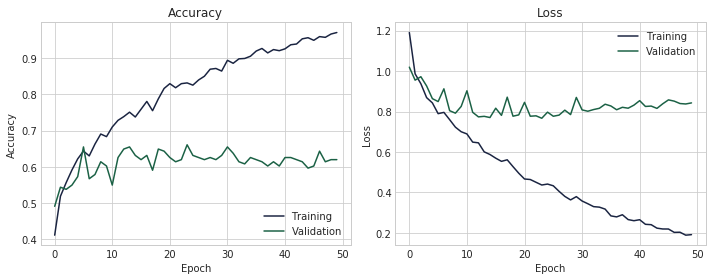

In [27]:
plot_metrics(d3_hist7)

Best Model:
epoch: 22 , val_acc: 0.6725146191859106 , val_loss: 0.7522323365099945


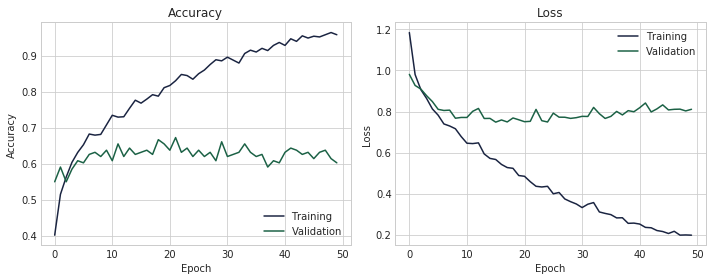

In [28]:
plot_metrics(d3_hist8)

## Finetuning Model

### Run 1 - With Regularization

In [29]:
plot_metrics(ft_d3_hist)

NameError: name 'ft_d3_hist' is not defined

### Run 2 - Without Regularization

In [ ]:
ft_d3_model, ft_d3_hist = finetune_categorical_model()

In [ ]:
plot_metrics(ft_d3_hist)

## Model Evaluation

In [ ]:
ft_d3_model = load_model('data3_1/120116_1223/ft_d3_model.h5') # without regularization, first run

In [ ]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [ ]:
evaluate_categorical_model(ft_d3_model, validation_data_dir, validation_labels) 

In [ ]:
ft_d3_model2 = load_model('data3_1/120316_0000/ft_model.h5') # with regularization, first run

In [ ]:
evaluate_categorical_model(ft_d3_model2, validation_data_dir, validation_labels)

In [ ]:
evaluate_categorical_model(ft_d3_model3, validation_data_dir, validation_labels)

## Load Model Point

In [ ]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,6))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print "Best Model:" 
    print_best_model_results(hist)

In [ ]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print ''
    print classification_report(validation_labels, pred_labels)
    print ''
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [ ]:
# WINNER
ft_model = load_model('data3_1/ft_model.h5')  # without regularization, second run

In [ ]:
with open('data3_1/ft_history.txt') as f:    
    ft_history = json.load(f)

In [ ]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [ ]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

In [ ]:
with open('data3_1/top_history.txt') as f:    
    top_history = json.load(f)

def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,7))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [ ]:
plot_acc_metrics(top_history, ft_history)

In [ ]:
heatmap_labels = ['Minor', 'Moderate', 'Severe']

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [ ]:
def severity_estimator(image_path, model):
    print "Determining severity of damage..."
    urllib.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    pred_label = np.argmax(pred, axis=1)
    
    d = {0: 'Minor', 1: 'Moderate', 2: 'Severe'}
    for key in d.iterkeys():
        if pred_label[0] == key:
            print "Assessment: {} damage to vehicle".format(d[key])
    print "Severity assessment complete."

In [ ]:
car_severity_estimator('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_d3_model3)

In [ ]:
car_severity_estimator('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_d3_model3)

In [ ]:
car_severity_estimator('http://1.bp.blogspot.com/-hzoFer11Gcw/Uw_b0Z8HGAI/AAAAAAAAA4M/XjV-NrRl0iM/s1600/20140227_140935.jpg', ft_d3_model3)

In [ ]:
severity_estimator('http://cdn.xl.thumbs.canstockphoto.com/canstock23892567.jpg', ft_d3_model3)

In [ ]:
severity_estimator('https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcQsEqgcb4vdQlWgsE7EaxfMed5n-v3MzE5nzxdayWgreSTBt2z5', ft_d3_model3)

## Looking at Edge Cases

In [ ]:
evaluate_categorical_model(ft_d3_model3, validation_data_dir, validation_labels)

In [ ]:
def get_edge_cases(model, directory, exp_result, false_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred = model.predict(x)
        pred_label = np.argmax(pred, axis=1)
        if pred_label[0] == false_result:
            edge_list.append(name)
    return edge_list

In [ ]:
minor1 = get_edge_cases(ft_d3_model3, 'data3_1/validation/01-minor/', 0, 1) # true minor, predicted moderate - 12
minor2 = get_edge_cases(ft_d3_model3, 'data3_1/validation/01-minor/', 0, 2) # true minor, predicted severe - 2

In [ ]:
moderate1 = get_edge_cases(ft_d3_model3, 'data3_1/validation/02-moderate/', 1, 0) # true moderate, predicted minor - 9
moderate2 = get_edge_cases(ft_d3_model3, 'data3_1/validation/02-moderate/', 1, 2) # true moderate, predicted severe - 10

In [ ]:
severe1 = get_edge_cases(ft_d3_model3, 'data3_1/validation/03-severe/', 2, 0) # true severe, predicted minor - 0
severe2 = get_edge_cases(ft_d3_model3, 'data3_1/validation/03-severe/', 2, 1) # true severe, predicted moderate - 20

In [ ]:
len(minor1) == 12, len(minor2) == 2, len(moderate1) == 9, len(moderate2) == 10, len(severe1) == 0, len(severe2) == 20

In [ ]:
view_images('data3_1/validation/01-minor/', minor1) # moderate

In [ ]:
view_images('data3_1/validation/01-minor/', minor2) # severe

In [ ]:
view_images('data3_1/validation/02-moderate/', moderate1) # minor

In [ ]:
view_images('data3_1/validation/02-moderate/', moderate2) # severe

In [ ]:
view_images('data3_1/validation/03-severe/', severe2) # moderate